In [2]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)
%matplotlib inline

In [3]:
# Reading the file & loading in the data
raw = mne.io.read_raw_fif("/Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/data/group9_own_AH_ver3-raw.fif")
raw.info['bads'] = []
print(raw.info['ch_names'])
raw.load_data()

Opening raw data file /Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/data/group9_own_AH_ver3-raw.fif...
    Range : 6700000 ... 7200000 =   6700.000 ...  7200.000 secs
Ready.
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', '41']
Reading 0 ... 500000  =      0.000 ...   500.000 secs...


Measurement date,"May 02, 2024 09:55:09 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


In [4]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

# common average reference
raw.set_eeg_reference('average', projection=True)

# applying the reference
raw.apply_proj()


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,"May 02, 2024 09:55:09 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


Using matplotlib as 2D backend.


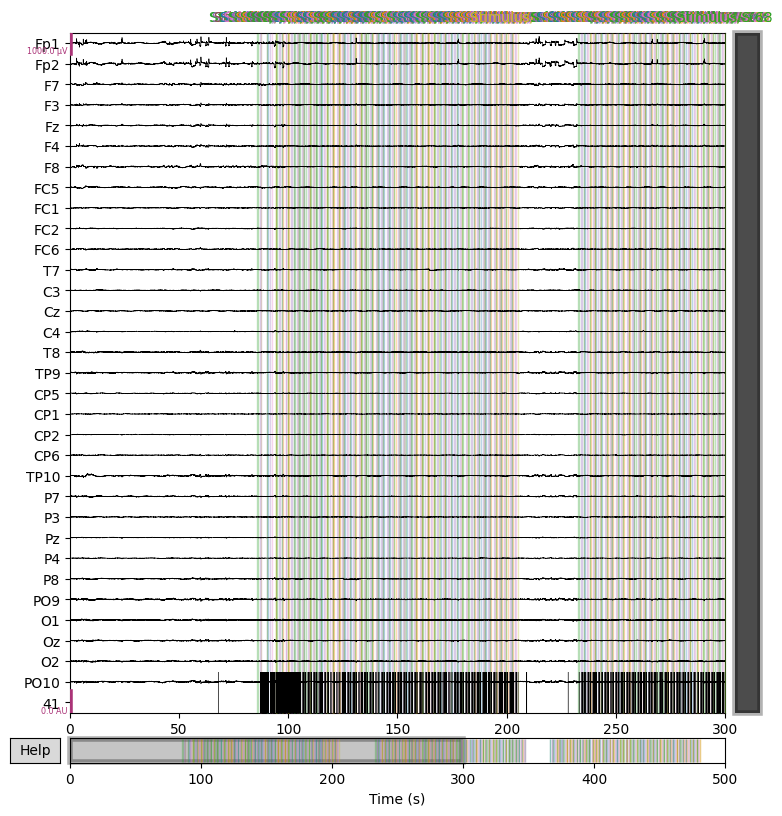

In [5]:
raw.plot(scalings=500e-6, n_channels=35, duration=300, start=0);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


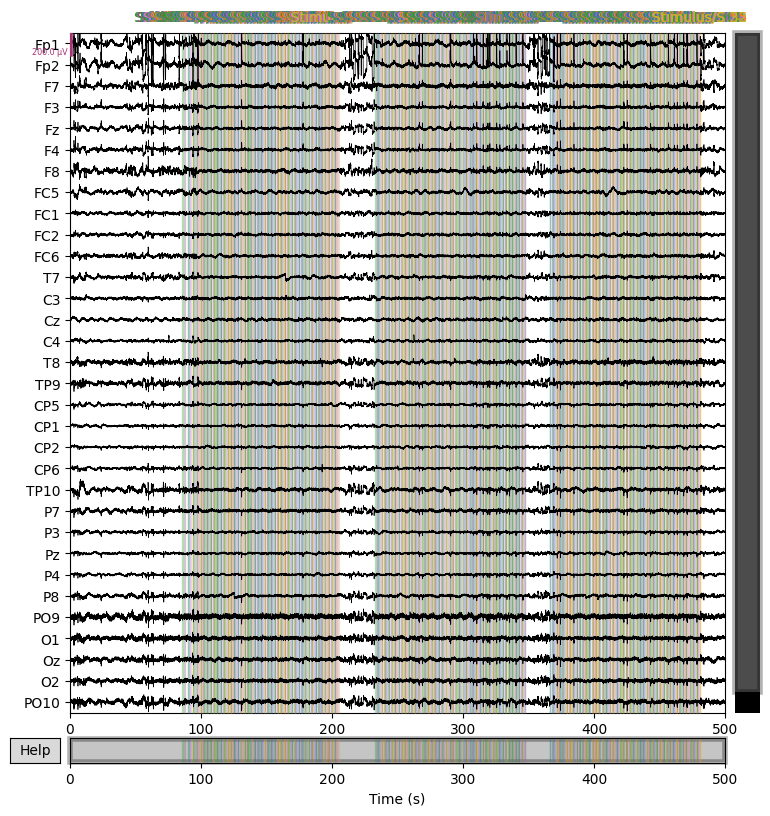

In [6]:
# Filtering data
raw.filter(.1, 40., fir_design="firwin")
raw.plot(n_channels=32, scalings=100e-6, duration=1500, start=0);

In [7]:
# Removing bads
raw.info["bads"] = ["P3", "PO10", "PO9"]
raw.pick(['eeg'], exclude="bads")

raw_fit = raw.copy().filter(1, 40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [8]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter=800)
ica.fit(raw_fit)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 7 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,25 iterations on raw data (500001 samples)
ICA components,7
Available PCA components,29
Channel types,eeg
ICA components marked for exclusion,—


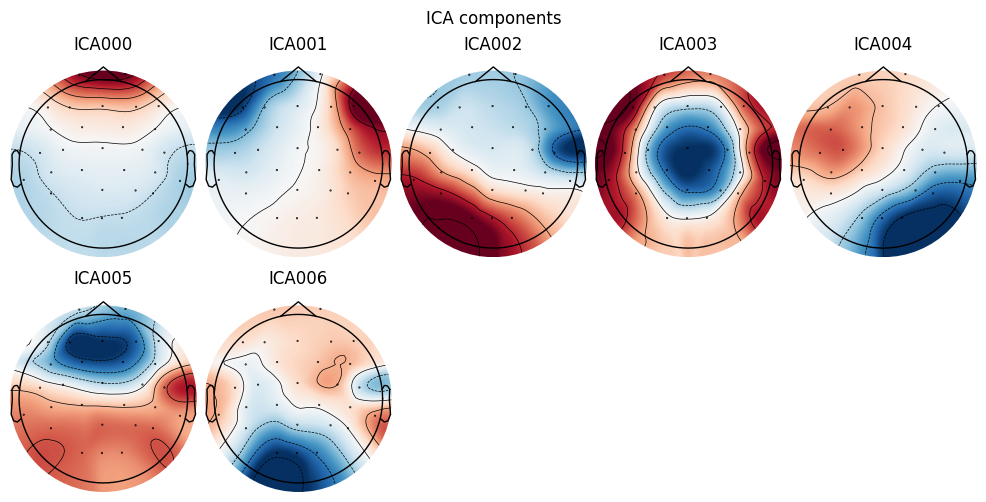

In [9]:
# Plot ICA components
ica.plot_components();

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=7, n_times=500001
    Range : 6700000 ... 7200000 =   6700.000 ...  7200.000 secs
Ready.


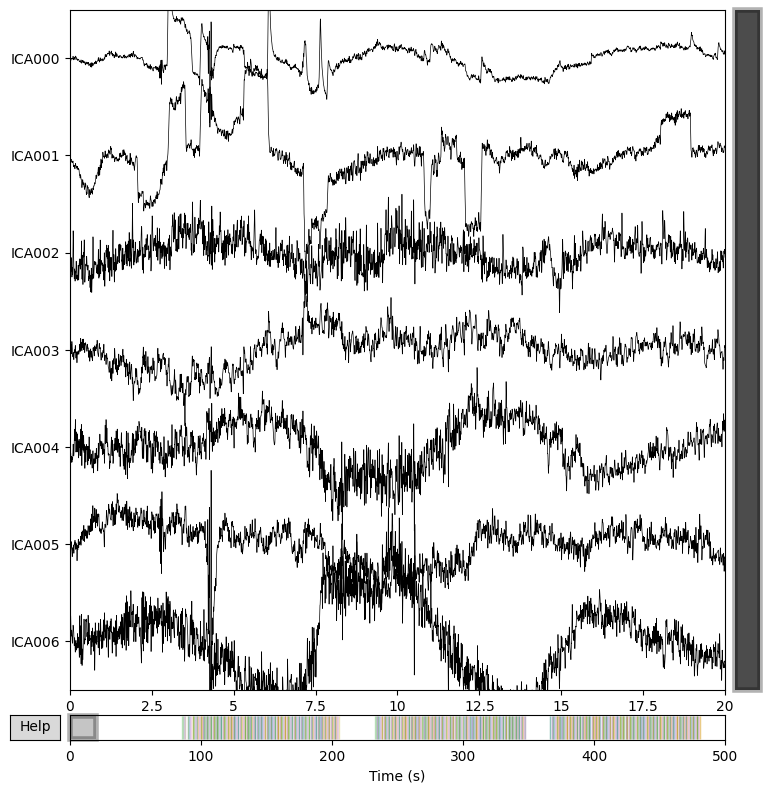

In [10]:
# Plot the time courses of ICA components
ica.plot_sources(raw, start=0);

In [11]:
# Function outputs an array and a list, naming both of these
events, event_boop = mne.events_from_annotations(raw)

event_boop

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 53', 'Stimulus/S 54', 'Stimulus/S 55', 'Stimulus/S 68', 'Stimulus/S 69']


{'Stimulus/S 11': 11,
 'Stimulus/S 12': 12,
 'Stimulus/S 13': 13,
 'Stimulus/S 21': 21,
 'Stimulus/S 22': 22,
 'Stimulus/S 23': 23,
 'Stimulus/S 31': 31,
 'Stimulus/S 32': 32,
 'Stimulus/S 53': 53,
 'Stimulus/S 54': 54,
 'Stimulus/S 55': 55,
 'Stimulus/S 68': 68,
 'Stimulus/S 69': 69}

In [12]:
# Remove spurious triggers (e.g., if dif < 2 ms)
dif_onsets = np.diff(events[:, 0])
dif_idx = np.where(dif_onsets < 2)[0]
events = np.delete(events, dif_idx, axis=0)
print(f"Events with index {dif_idx} were rejected.")

Events with index [  9  20  41  47  53  59  65  71  92  98 104 145 151 157 163 174 255 286
 302 323 334 345 396 407 418 424 430 446 452 488 504 510 516 522 538 544
 550 556 562 568 584 595 601 612 623 639 650 661 672 688 709 715 721 727] were rejected.


In [13]:
# Shifting data to fit diode
events_diode = events.copy()

# List of triggers to be shifted by 16ms
triggers_16ms = [11, 12, 13]

# List of triggers to be shifted by 33.33ms
triggers_33ms = [21, 22, 23]

for event in events:
    trigger = event[2]
    if trigger in triggers_16ms:
        event[0] += 16
    elif trigger in triggers_33ms:
        event[0] += 33.33

events[:20, :]

array([[6785524,       0,      68],
       [6786110,       0,      13],
       [6787091,       0,      69],
       [6787641,       0,      22],
       [6790266,       0,      31],
       [6790274,       0,      68],
       [6790790,       0,      11],
       [6791774,       0,      69],
       [6792324,       0,      23],
       [6794196,       0,      32],
       [6794208,       0,      68],
       [6794657,       0,      13],
       [6795641,       0,      69],
       [6796207,       0,      21],
       [6797211,       0,      31],
       [6797224,       0,      68],
       [6797740,       0,      12],
       [6798725,       0,      69],
       [6799174,       0,      23],
       [6799845,       0,      32]])

In [14]:
# Define a dictionary to map current trigger numbers to new trigger numbers
#trigger_mapping = {
 #   1: 11,  # Prime masculine
    #  2: 12,  # Prime feminine
    #3: 13,  # Prime neutral
    #4: 21,  # Target masculine
    #5: 22,  # Target feminine
    #6: 23,  # Target non-word
    #7: 31,  # Key press yes
    #8: 32,  # Key press no
   #11: 68, # Fixation 1
    #12: 69  # Fixation 2
#}

# Loop through the array and update the trigger numbers according to the mapping
#for event in events:
    #if event[2] in trigger_mapping:
       # event[2] = trigger_mapping[event[2]]

# Print the first 20 events to verify the changes
#print(events[:20])

In [15]:
# Adjust the loop to stop 2 indices earlier to account for the i + 2 access
for i in range(len(events) - 2):  # Ensure we don't go out of bounds
    # Extract the event_id for the current event (prime) and the next relevant event (target)
    current_event_id = events[i][2]  # Prime event ID
    next_event_id = events[i + 2][2]  # Target event ID, skipping the fixation

    # Update the event_id based on the specified conditions, targeting the next event ID
    if current_event_id == 11:  # Prime/M
        if next_event_id == 21:  # Target/M
            events[i + 2][2] = 101  # Update target event ID for Prime/M -> Target/M
        elif next_event_id == 22:  # Target/F
            events[i + 2][2] = 201  # Update target event ID for Prime/M -> Target/F
        elif next_event_id == 23:  # Target/NW
            events[i + 2][2] = 500  # Update target event ID for Prime/M -> Target/NW

    elif current_event_id == 12:  # Prime/F
        if next_event_id == 21:  # Target/M
            events[i + 2][2] = 202  # Update target event ID for Prime/F -> Target/M
        elif next_event_id == 22:  # Target/F
            events[i + 2][2] = 102  # Update target event ID for Prime/F -> Target/F
        elif next_event_id == 23:  # Target/NW
            events[i + 2][2] = 500  # Update target event ID for Prime/F -> Target/NW

    elif current_event_id == 13:  # Prime/N
        if next_event_id == 21:  # Target/M
            events[i + 2][2] = 111  # Update target event ID for Prime/N -> Target/M
        elif next_event_id == 22:  # Target/F
            events[i + 2][2] = 112  # Update target event ID for Prime/N -> Target/F
        elif next_event_id == 23:  # Target/NW
            events[i + 2][2] = 500  # Update target event ID for Prime/N -> Target/NW
events[:20]


array([[6785524,       0,      68],
       [6786110,       0,      13],
       [6787091,       0,      69],
       [6787641,       0,     112],
       [6790266,       0,      31],
       [6790274,       0,      68],
       [6790790,       0,      11],
       [6791774,       0,      69],
       [6792324,       0,     500],
       [6794196,       0,      32],
       [6794208,       0,      68],
       [6794657,       0,      13],
       [6795641,       0,      69],
       [6796207,       0,     111],
       [6797211,       0,      31],
       [6797224,       0,      68],
       [6797740,       0,      12],
       [6798725,       0,      69],
       [6799174,       0,     500],
       [6799845,       0,      32]])

In [16]:
# Renaming events
event_id = {'Prime_M': 11, # prime masculine
 'Prime_F': 12, # prime feminine
 'Prime_N': 13, # prime neutral
 'Congruent_M': 101,
 'Incongruent_MF': 201, 
 'Incongruent_FM': 202,
 'Congruent_F': 102,
 'Nonword': 500, # target nonword
 'Neutral_M': 111,
 'Neutral_F': 112,
 'Fixation1': 68, # fixation 1
 'Fixation2': 69, # fixation 2
 'Key_Yes': 31, # key yes
 'Key_No': 32 # key no
 }
 

/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_75407/2038487891.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);


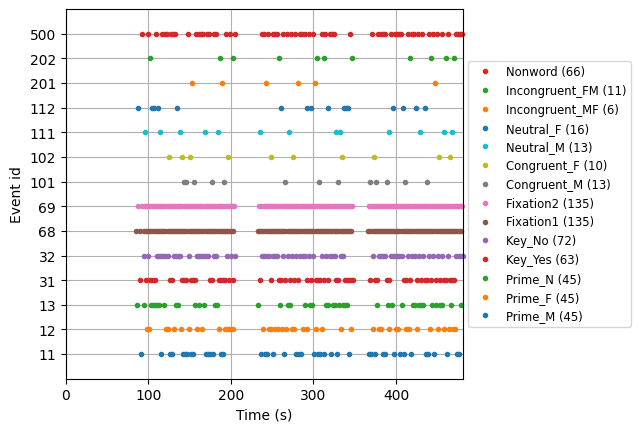

In [17]:
# Plot an overview of events
mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);

In [18]:
events[:20, :]

array([[6785524,       0,      68],
       [6786110,       0,      13],
       [6787091,       0,      69],
       [6787641,       0,     112],
       [6790266,       0,      31],
       [6790274,       0,      68],
       [6790790,       0,      11],
       [6791774,       0,      69],
       [6792324,       0,     500],
       [6794196,       0,      32],
       [6794208,       0,      68],
       [6794657,       0,      13],
       [6795641,       0,      69],
       [6796207,       0,     111],
       [6797211,       0,      31],
       [6797224,       0,      68],
       [6797740,       0,      12],
       [6798725,       0,      69],
       [6799174,       0,     500],
       [6799845,       0,      32]])

In [19]:
output_path = os.path.join(os.getcwd(), "shifted_data")

# make sure output path exists 
if not os.path.exists(output_path):
    os.mkdir(output_path)

# save the data
raw.save(os.path.join(output_path, 'shifted_data.fif'), overwrite=True)

Overwriting existing file.
Writing /Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/shifted_data/shifted_data.fif


/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_75407/2345929755.py:8: RuntimeWarning: This filename (/Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/shifted_data/shifted_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(os.path.join(output_path, 'shifted_data.fif'), overwrite=True)


Closing /Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/shifted_data/shifted_data.fif
[done]


In [20]:
# Creating a time window -100 to 700 ms 
tmin, tmax = -0.1, 1

# Reject criterion
reject = {'eeg': 150e-6}
picks = ['eeg']

Not setting metadata
675 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 675 events and 1101 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoc

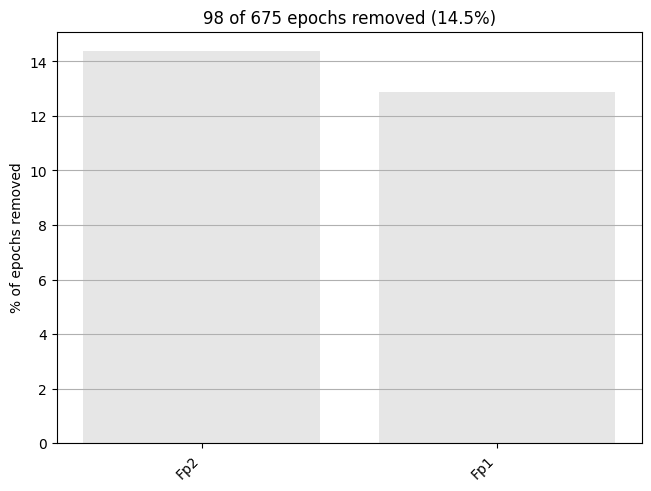

In [21]:
# Checking bad epochs
epochs = mne.Epochs(
    raw, 
    events = events, 
    event_id = event_id, 
    tmin = tmin, 
    tmax = tmax, 
    picks = picks, 
    baseline = (tmin, 0), 
    preload = True
    )

dummy = epochs.copy()

dummy.drop_bad(reject=reject)
dummy.plot_drop_log();

In [22]:
#aw.info["bads"] = ["P3", "PO10", "PO9"]

# Excluding the bads
raw.pick(['eeg'], exclude="bads")

Measurement date,"May 02, 2024 09:55:09 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,29 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


Not setting metadata
675 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 675 events and 1101 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoc

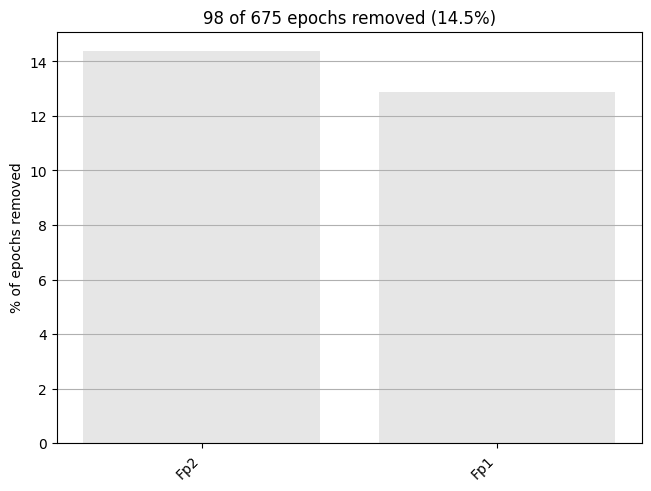

In [23]:
# Checking bad epochs
epochs = mne.Epochs(
    raw, 
    events = events, 
    event_id = event_id, 
    tmin = tmin, 
    tmax = tmax, 
    picks = picks, 
    baseline = (tmin, 0), 
    preload = True
    )

dummy = epochs.copy()

dummy.drop_bad(reject=reject)
dummy.plot_drop_log();

In [24]:
# Downsample to 250Hz
epochs.resample(250)

Number of events,675
Events,Congruent_F: 10Congruent_M: 13Fixation1: 135Fixation2: 135Incongruent_FM: 11Incongruent_MF: 6Key_No: 72Key_Yes: 63Neutral_F: 16Neutral_M: 13Nonword: 66Prime_F: 45Prime_M: 45Prime_N: 45
Time range,-0.100 – 0.996 s
Baseline,-0.100 – 0.000 s


In [25]:
# Prime epochs
prime_m_epochs = epochs["Prime_M"]  # Prime events with masculine stimulus
prime_f_epochs = epochs["Prime_F"]  # Prime events with feminine stimulus
prime_n_epochs = epochs["Prime_N"]  # Prime events with neutral stimulus
all_prime = epochs["Prime_M", "Prime_F", "Prime_N"]  # All prime events

# Conditions
incongruent_MF_epochs = epochs["Incongruent_MF"]
incongruent_FM_epochs = epochs["Incongruent_FM"]  
congruent_m_epochs = epochs["Congruent_M"] 
congruent_f_epochs = epochs["Congruent_F"]

# Conditions combined
incongruent_epochs = epochs["Incongruent_MF", "Incongruent_FM"]
congruent_epochs = epochs["Congruent_M", "Congruent_F"]
neutral_epochs = epochs["Neutral_M", "Neutral_F"]
all_target = epochs["Incongruent_MF", "Incongruent_FM", "Congruent_M", "Congruent_F"]
# Fixation epochs
fixation1_epochs = epochs["Fixation1"]  # First fixation events
fixation2_epochs = epochs["Fixation2"]  # Second fixation events

# Key press
key_yes_epochs = epochs["Key_Yes"]
key_no_epochs = epochs["Key_No"]

all_words = epochs["Incongruent_MF", "Incongruent_FM", "Congruent_M", "Congruent_F", "Prime_M", "Prime_F", "Prime_N", "Nonword"]


Not setting metadata
241 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


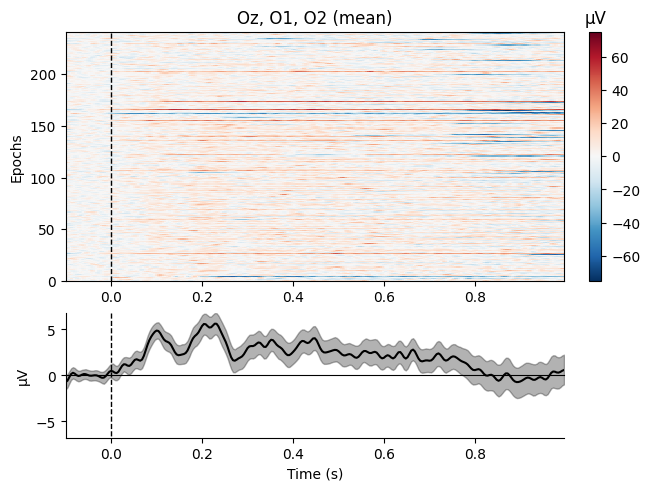

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


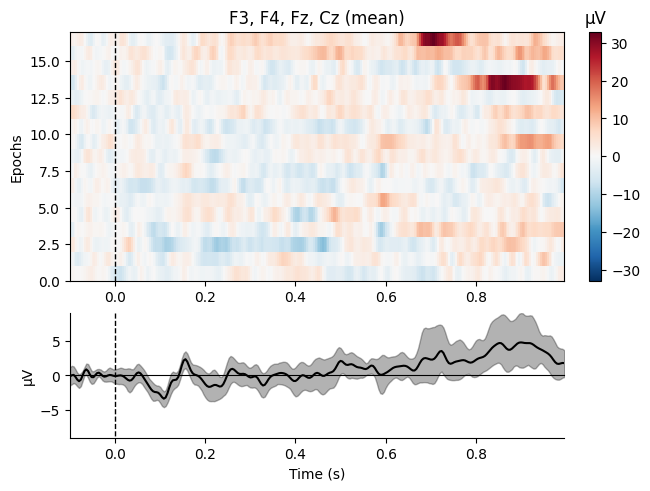

[<Figure size 640x480 with 3 Axes>]

In [26]:
all_words.plot_image(picks=["Oz", "O1", "O2"], combine="mean")
incongruent_epochs.plot_image(picks=["F3", "F4", "Fz", "Cz"], combine="mean")

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


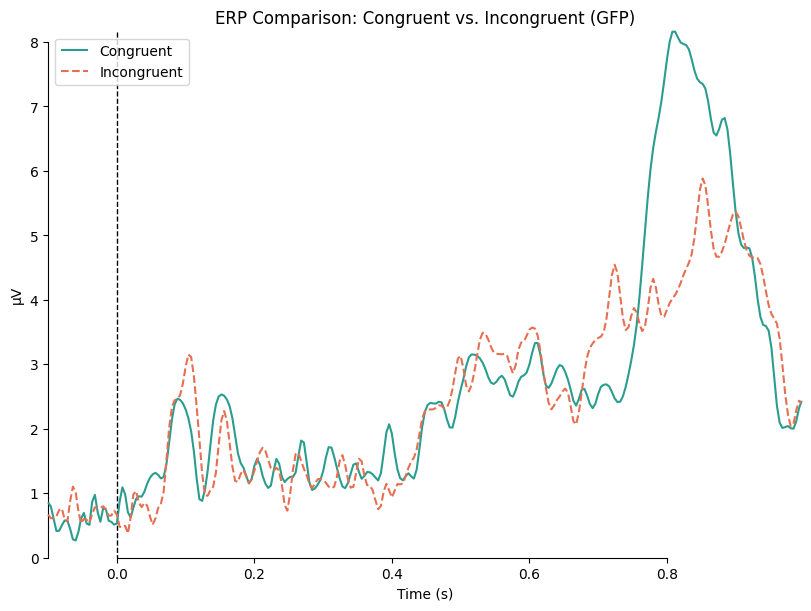

In [27]:
# making evoked variables
evoked_congruent = congruent_epochs.average()
evoked_incongruent= incongruent_epochs.average()

# Plot the evokeds with custom colors
figs = mne.viz.plot_compare_evokeds(
    {"Congruent": evoked_congruent, "Incongruent": evoked_incongruent},
    colors={'Congruent': '#2a9d8f', 'Incongruent': '#e76f51'},  # Apply custom colors
    linestyles={'Congruent': '-', 'Incongruent': '--'},  # Different line styles
    title='ERP Comparison: Congruent vs. Incongruent',  # Custom title
    ci=True  # Show confidence intervals if available
)


Projections have already been applied. Setting proj attribute to True.


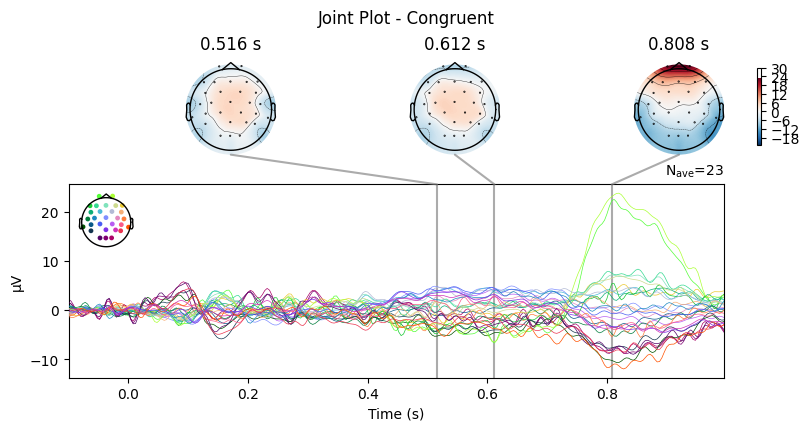

Projections have already been applied. Setting proj attribute to True.


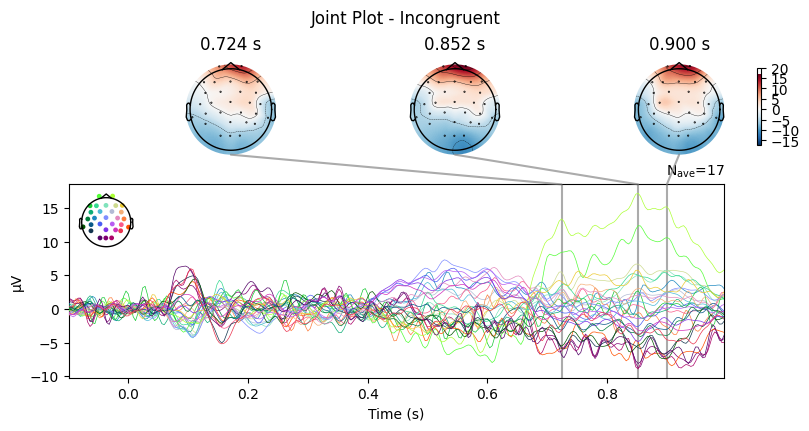

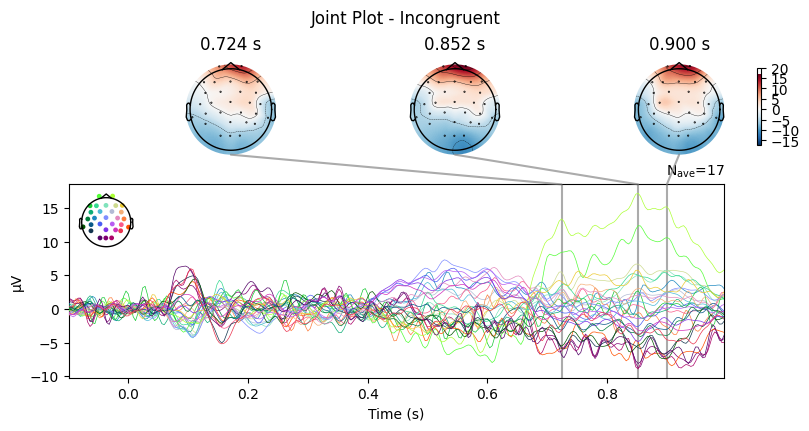

In [28]:
evoked_congruent.plot_joint(title='Joint Plot - Congruent', ts_args=dict(time_unit='s'), topomap_args=dict(time_unit='s'))
evoked_incongruent.plot_joint(title='Joint Plot - Incongruent', ts_args=dict(time_unit='s'), topomap_args=dict(time_unit='s'))

In [29]:
outpath = os.path.join(os.getcwd(), 'epochs')

if not os.path.exists(outpath):
    os.makedirs(outpath)

epochs.save(os.path.join(outpath, 'epochs-epo1.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.


/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_75407/1036106501.py:6: RuntimeWarning: This filename (/Users/sorenmeiner/Desktop/cogsci/Neuro/EEG/exam_eeg/own_experiment/epochs/epochs-epo1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(outpath, 'epochs-epo1.fif'), overwrite=True)
